In [1]:
import numpy as np
from surfinpy import utils as ut
from surfinpy import data

In [2]:
###############################
# qha_data.py
################################
import numpy as np
from surfinpy import utils as ut
from scipy.interpolate import CubicSpline

def qha_calc(qha_file, temp_r,f_units,cation):
    """
    docstring
    """
    gibbs=[]
    gibbs = np.genfromtxt(qha_file)
    gibbs = gibbs.T

    gibbs = fit(gibbs[0],gibbs[1],temp_r)
    gibbs = np.multiply(gibbs,np.divide(cation,f_units))
    return(gibbs)

def fit(x, y, t):
    '''Fit a polynominal function to thermochemical data from NIST_JANAF

    Parameters
    ----------
    x : :py:attr:`array_like`
        x axis for fit
    y : :py:attr:`array_like`
        y axis for fit
    t : :py:attr:`array_like`
        x axis to be fitted

    Returns
    -------
    shift : :py:attr:`array_like`
        data fitted from x and y to t
    '''
    z = CubicSpline(x, y, bc_type='clamped')
    shift = z(t)
    return shift


In [3]:
###############################
# data.py
################################

import numpy as np
from surfinpy import vibrational_data as vd
# from surfinpy import qha_data as qha

class ReferenceDataSet():
    """Object that contains information about the reference DFT calculation
    to be used in the phase diagram calculation. This object is
    used in both the surface and bulk phase diagram methods.

    Parameters
    ----------
    cation : :py:attr:`int`
        Number of cations in reference dataset
    anion :  :py:attr:`int`
        Number of anions in reference dataset
    energy : :py:attr:`float`
        DFT evaluated energy of reference dataset
    funits : :py:attr:`int`
        Number of formula units in reference dataset
    color : :py:attr:`string`
        Desired color of this phase in the phase diagram
    file : :py:attr:`str`):
        yaml file containing vibrational frequencies
    entropy : :py:attr:`bool`
        Is entropy to be considered?
    temp_range : :py:attr:`list`
        Temperature range to calculate vibrational entropy across
    zpe : :py:attr:`bool`
        Is the zero point energy to be considered?
    """
    def __init__(self, cation, anion, energy, funits, color=None,
                 file=None, entropy=False, temp_range=None,
                 zpe=False, qha=False):
        self.cation = cation
        self.anion = anion
        self.energy = energy
        self.funits = funits
        self.file = file
        self.color = color
        self.entropy = entropy
        self.temp_range = temp_range
        self.zpe = 0
        self.svib = 0
        self.temperature = 0
        self.zpe = zpe
        self.qha = qha
        if self.entropy:
            self.temp_r = np.arange(self.temp_range[0],
                                    self.temp_range[1], 
                                    1, dtype="float")
            self.svib = vd.vib_calc(self.file, self.temp_r)[1]
            self.temperature = self.temp_r[0]

        if self.zpe:
            self.temp_r = np.arange(self.temp_range[0],
                                    self.temp_range[1], 
                                    1, dtype="float")
            self.zpe = vd.vib_calc(self.file, self.temp_r)[0]
            self.temperature = self.temp_r[0]
        if self.qha:
            self.temp_r = np.arange(self.temp_range[0],
                                    self.temp_range[1],
                                    1, dtype="float")
            self.qha = qha_calc(self.file, self.temp_r,self.funits,self.cation)
            self.temperature = self.temp_r[0]

class DataSet():
    """Object that contains information about a DFT calculation
    to be added to the phase diagram calculation. This object is
    used in both the surface and bulk phase diagram methods.

    Parameters
    ----------
    cation : :py:attr:`int`
        Number of cations in dataset
    x :  :py:attr:`int`
        Number of species x in dataset
    y :  :py:attr:`int`
        Number of species y in dataset
    energy : :py:attr:`float`
        DFT evaluated energy of reference dataset
    label : :py:attr:`str`
        Label of dataset to be used in phase diagram
    color : :py:attr:`string`
        Desired color of this phase in the phase diagram
    funits : :py:attr:`int`
        Number of formula units in dataset
    file : :py:attr:`str`
        yaml file containing vibrational frequencies
    area : :py:attr:`float`
        Surface area - required for surface calculations
    nspecies : :py:attr:`int`
        Number of species that are constituent parts of the surface.
    entropy : :py:attr:`bool`
        Is entropy to be considered?
    temp_range : :py:attr:`list`
        Temperature range to calculate vibrational entropy across
    zpe : :py:attr:`bool`
        Is the zero point energy to be considered?
    """
    def __init__(self, cation, x, y, energy, label, color=None, funits=0, 
                 file=None, area=None, nspecies=None, entropy=False,
                 temp_range=False, zpe=False, qha=False):
        self.cation = cation
        self.x = x
        self.y = y
        self.energy = energy
        self.label= label
        self.color = color
        self.funits = funits
        self.file = file 
        self.area = area
        self.nspecies = nspecies
        self.entropy = entropy
        self.temp_range = temp_range
        self.zpe = 0
        self.svib = 0
        self.temperature = 0
        self.qha = qha
        if self.entropy:
            self.temp_r = np.arange(self.temp_range[0],
                                    self.temp_range[1], 
                                    1, dtype="float")
            self.svib = vd.vib_calc(self.file, self.temp_r)[1]
            self.temperature = self.temp_r[0]

        if self.zpe:
            self.temp_r = np.arange(self.temp_range[0],
                                    self.temp_range[1], 
                                    1, dtype="float")
            self.zpe = vd.vib_calc(self.file, self.temp_r)[0]
            self.temperature = self.temp_r[0]
        if self.qha:
            self.temp_r = np.arange(self.temp_range[0],
                                    self.temp_range[1],
                                    1, dtype="float")
            self.qha = qha_calc(self.file, self.temp_r,self.funits, self.cation)
            self.temperature = self.temp_r[0]

In [4]:
###############################
# qha_mu_vs_mu.py
################################

import numpy as np
from surfinpy import plotting
from surfinpy import utils as ut
import sys

def normalise_phase_energy(phase, bulk):
    r"""
    Converts normalises each phase to be consistent with the bulk.
    DFT calculations may have differing numbers of formula units compared to
    the bulk and this must be accounted for. Furthermore, the vibrational entropy
    and zero point energy are accounted for (if required).

    Parameters
    ----------
    phase : :py:class:`surfinpy.data.DataSet`
        surfinpy dataset object.
    bulk : :py:class:`surfinpy.data.DataSet`
        surfinpy ReferenceDataSet object.

    Returns
    -------
    :py:attr:`float`
        Normalised phase energy
    """
    return (phase.qha  - (phase.cation / bulk.cation)
            * (bulk.qha / bulk.funits))

def calculate_bulk_energy(deltamux, deltamuy, x_energy, y_energy,
                          phase, normalised_bulk):
    r"""Calculates the free energy of a given phase (DFT calculation)
    as a function of chemical potential of x and y.

    Parameters
    ----------
    deltamux : :py:attr:`array_like`
        Chemical potential of species x
    deltamuy : :py:attr:`array_like`
        Chemical potential of species y
    x_energy : :py:attr:`float`
        DFT energy or temperature corrected DFT energy
    y_energy : :py:attr:`float`
        DFT energy or temperature corrected DFT energy
    phase : :py:class:`surfinpy.data.DataSet`
        DFT calculation 
    normalised_bulk : :py:attr:`float`
        Bulk energy normalised to the bulk value.

    Returns
    -------
    :py:attr:`array_like`
        2D array of free energies as a function of
        chemical potential of x and y
    """

    return (
        normalised_bulk - deltamux* phase.x - deltamuy* phase.y - (
        x_energy * phase.x) - (y_energy * phase.y))

def evaluate_phases(data, bulk, x, y, nphases, x_energy, y_energy):
    """Calculates the free energies of each phase as a function of chemical
    potential of x and y. Then uses this data to evaluate which phase is most
    stable at that x/y chemical potential cross section.

    Parameters
    ----------
    data : :py:attr:`list`
        List of :py:class:`surfinpy.data.DataSet` objects
    bulk : :py:class:`surfinpy.data.ReferenceDataSet` object
        Reference dataset
    x : :py:attr:`dict`
        X axis chemical potential values
    y : :py:attr:`dict`
        Y axis chemical potential values
    nphases : :py:attr:`int`
        Number of phases
    x_energy : :py:attr:`float`
        DFT 0 K energy for species x
    y_energy : :py:attr:`float`
        DFT 0 K energy for species y

    Returns
    -------
    phase_data  : :py:attr:`array_like`
        array of ints, with each int corresponding to a phase.
    """
    xnew = ut.build_xgrid(x, y)
    ynew = ut.build_ygrid(x, y)
    S = np.array([])
    for k in range(0, nphases):
        normalised_bulk = normalise_phase_energy(data[k], bulk)

        SE = calculate_bulk_energy(xnew, ynew, 
                                   x_energy,
                                   y_energy,
                                   data[k],
                                   normalised_bulk)
        S = np.append(S, SE)

    phase_data, SE = ut.get_phase_data(S, nphases)
    return phase_data, SE

def calculate(data, bulk, deltaX, deltaY, x_energy, y_energy):
    """Initialise the free energy calculation.

    Parameters
    ----------
    data : :py:attr:`list`
        List of :py:class:`surfinpy.data.DataSet` object for each phase
    bulk : :py:class:`surfinpy.data.ReferenceDataSet`
        Reference dataset
    deltaX : :py:attr:`dict`
        Range of chemical potential/label for species X 
    DeltaY : :py:attr:`dict`
        Range of chemical potential/label for species Y 
    x_energy : :py:attr:`float`
        DFT energy of adsorbing species
    y_energy : :py:attr:`float`
        DFT energy of adsorbing species

    Returns
    -------
    system : :py:class:`surfinpy.plotting.ChemicalPotentialPlot`
        Plotting object
    """
    nphases = len(data)
    X = np.arange(deltaX['Range'][0], deltaX['Range'][1],
                  0.005, dtype="float")
    Y = np.arange(deltaY['Range'][0], deltaY['Range'][1],
                  0.005, dtype="float")  

    phases, SE = evaluate_phases(data, bulk, X, Y,
                                 nphases, x_energy, y_energy)

    ticks = np.unique([phases])
    colors = ut.list_colors(data, ticks)
    phases = ut.transform_numbers(phases, ticks)
    Z = np.reshape(phases, (Y.size, X.size))
    SE = np.reshape(SE, (Y.size, X.size))
    labels = ut.get_labels(ticks, data)

    system = plotting.ChemicalPotentialPlot(X,
                                            Y,
                                            Z,
                                            labels,
                                            ticks,
                                            colors,
                                            deltaX['Label'],
                                            deltaY['Label'])
    return system


In [29]:
###################################################################################################################################
#               NOTEBOOK Example Mu vs. Mu QHA
###################################################################################################################################

colors = ['#5B9BD5', '#4472C4', '#A5A5A5', '#772C24', '#ED7D31', '#FFC000', '#70AD47']

In [30]:
temperature_range = [298, 299]

In [31]:
bulk = ReferenceDataSet(cation = 10, anion = 10, energy = -3.75E+01, funits = 2.5, file = 'ref_files/Bulk_gibbs-temperature.dat', qha=True, temp_range=temperature_range)

In [32]:
Bulk = DataSet(cation = 10, x = 0, y = 0, energy=-37.5, color=colors[0],
                    label = "Bulk", qha=True, file = 'ref_files/Bulk_gibbs-temperature.dat', 
                    funits = 4, temp_range=temperature_range)

A = DataSet(cation = 10, x = 5, y = 20, energy=-387.454, color=colors[4],
                   label = "A", qha=True, file = 'ref_files/A_gibbs-temperature.dat', 
                   funits = 8, temp_range=temperature_range)

B = DataSet(cation = 10, x = 0, y = 10, energy=-23.488, color=colors[2],
                   label = "B", qha=True, file = 'ref_files/B_gibbs-temperature.dat', 
                   funits =  1, temp_range=temperature_range)

C = DataSet(cation = 10, x = 10, y = 30, energy=-292.638, color=colors[5],
                   label = "C", qha=True, file = 'ref_files/C_gibbs-temperature.dat', 
                   funits = 4, temp_range=temperature_range)

D = DataSet(cation = 10, x = 10, y = 0, energy=-189.0,  color=colors[1],
                   label = "D", qha=True,  file = 'ref_files/D_gibbs-temperature.dat', 
                   funits =  6, temp_range=temperature_range)

E = DataSet(cation = 10, x = 10, y = 50, energy=-404.543, color=colors[6],
                   label = "E", qha=True, file = 'ref_files/E_gibbs-temperature.dat', 
                   funits =  4, temp_range=temperature_range)

F = DataSet(cation = 10, x = 8, y = 10, energy=409.962, color=colors[3],
                   label = "F", qha=True, file = 'ref_files/F_gibbs-temperature.dat', 
                   funits =  10, temp_range=temperature_range)

In [33]:
data = [Bulk, A, B, C,  D, E, F]

In [34]:
x_energy=-20.53412969
y_energy=-12.83725889

In [35]:
CO2_exp = ut.fit_nist("ref_files/CO2.txt")[298]
Water_exp = ut.fit_nist("ref_files/H2O.txt")[298]

CO2_corrected = x_energy + CO2_exp
Water_corrected = y_energy + Water_exp

deltaX = {'Range': [ -1, 0.6],  'Label': 'CO_2'}
deltaY = {'Range': [ -1, 0.6], 'Label': 'H_2O'}

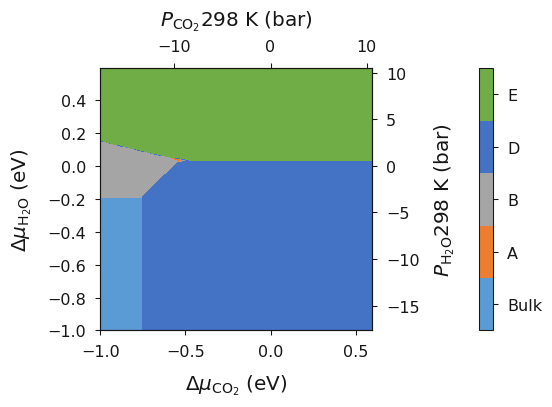

In [36]:
temp_298 = calculate(data, bulk, deltaX, deltaY, CO2_corrected, Water_corrected)
ax = temp_298.plot_mu_p(temperature=298, figsize=(6, 4.5))